In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')

In [25]:
data_lag = pd.read_csv("data_lagged.csv")
data = pd.read_csv('data_vad.csv')

In [26]:
data = data.drop(["filename"], axis = 1).dropna()

### Разделение данных

In [27]:
def data_separation(data, train_size):
    X1 = data[data["label"] == 1]["batch_id"].unique()
    X2 = data[data["label"] == 2]["batch_id"].unique()
    X3 = data[data["label"] == 3]["batch_id"].unique()
    X1_train, X1_test = train_test_split(X1,train_size = train_size, random_state = 42)
    X2_train, X2_test = train_test_split(X2,train_size = train_size, random_state = 42)
    X3_train, X3_test = train_test_split(X3,train_size = train_size, random_state = 42)
    X_train = [*X1_train, *X2_train, *X3_train]
    X_test = [*X1_test, *X2_test, *X3_test]
    data_train = data[data["batch_id"].apply(lambda x: x in X_train)]
    data_test = data[data["batch_id"].apply(lambda x: x in X_test)]
    return data_train, data_test

In [28]:
# Отложенные и тренировочные наборы
data_train, data_test = data_separation(data, 0.7)
data_train_lag, data_test_lag = data_separation(data_lag, 0.7)

In [29]:
# Валидационные наборы
data_val = data_separation(data_train, 0.2)[0]
data_val_lag = data_separation(data_train_lag, 0.2)[0]

In [30]:
data_train = data_train.drop(['msec', 'label', 'batch_id'], axis = 1)
data_train_lag = data_train_lag.drop(['msec', 'label', 'batch_id'], axis = 1)
data_test = data_test.drop(['msec', 'label', 'batch_id'], axis = 1)
data_test_lag = data_test_lag.drop(['msec', 'label', 'batch_id'], axis = 1)
data_val = data_val.drop(['msec', 'label', 'batch_id'], axis = 1)
data_val_lag = data_val_lag.drop(['msec', 'label', 'batch_id'], axis = 1)

In [31]:
# для данных без погружения
X = data_train.iloc[:,:3]
X_test = data_test.iloc[:,:3]
y_valence = data_train.iloc[:,3:4]
y_arousal = data_train.iloc[:,4:]
y_valence_test = data_test.iloc[:,3:4]
y_arousal_test = data_test.iloc[:,4:]
X_val = data_val.iloc[:,:3]
y_valence_val = data_val.iloc[:,3:4]
y_arousal_val = data_val.iloc[:,4:]

In [32]:
# для данных с погружением
X_lag = data_train_lag.drop(['Valence', 'Arousal'], axis = 1)
X_test_lag = data_test_lag.drop(['Valence', 'Arousal'], axis = 1)
y_valence_lag = data_train_lag.iloc[:,3:4]
y_arousal_lag = data_train_lag.iloc[:,4:5]
y_valence_test_lag = data_test_lag.iloc[:,3:4]
y_arousal_test_lag = data_test_lag.iloc[:,4:5]
X_val_lag = data_val_lag.drop(['Valence', 'Arousal'], axis = 1)
y_valence_val_lag = data_val_lag.iloc[:,3:4]
y_arousal_val_lag = data_val_lag.iloc[:,4:5]

### Стандартизация данных

In [33]:
mean = X.mean(axis = 0)
mean_lag = X_lag.mean(axis = 0)
std = X.std(axis = 0)
std_lag = X_lag.std(axis = 0)

In [34]:
X -= mean
X_lag -= mean_lag
X /= std
X_lag /= std_lag

In [35]:
X_test -= mean
X_test_lag -= mean_lag
X_test /= std
X_test_lag /= std_lag

In [36]:
X_val -= mean
X_val_lag -= mean_lag
X_val /= std
X_val_lag /= std_lag

### Общая функция оценки моделей

In [50]:
def model_NN(X, y, X_test, y_test, X_val, y_val, input_n, output_n):
    tf.random.set_seed(221)
    model = Sequential()
    model.add(Dense(input_n, input_dim = input_n, activation = 'relu'))
    model.add(Dense(output_n, activation = 'linear'))
    model.compile(loss = 'mse', optimizer = 'adam')
    history = model.fit(X, y, epochs = 300, validation_data = (X_val, y_val), verbose = 0)
    
    m = {"R2_train":{},"MAE_train":{},"MSE_train":{}, "R2_test":{},"MAE_test":{},"MSE_test":{}}
    m["R2_train"]['SingleLayerPerceptron'] = r2_score(y, model.predict(X, verbose = 0))
    m["MAE_train"]['SingleLayerPerceptron'] = mean_absolute_error(y, model.predict(X, verbose = 0))
    m["MSE_train"]['SingleLayerPerceptron'] = mean_squared_error(y, model.predict(X, verbose = 0))
    m["R2_test"]['SingleLayerPerceptron'] = r2_score(y_test, model.predict(X_test, verbose = 0))
    m["MAE_test"]['SingleLayerPerceptron'] = mean_absolute_error(y_test, model.predict(X_test, verbose = 0))
    m["MSE_test"]['SingleLayerPerceptron'] = mean_squared_error(y_test, model.predict(X_test, verbose = 0))
    return pd.DataFrame(m), history

In [51]:
def plot_history(history, name, lim):
    plt.plot(history.history["loss"], label = 'train')
    plt.plot(history.history["val_loss"], label = 'val')
    plt.xlabel('epochs')
    plt.ylabel('mse')
    plt.title(name)
    plt.legend()
    plt.ylim(lim)
    plt.grid(True)

### Модели без погружения

In [52]:
mtv, history_valence = model_NN(X, y_valence, X_test, y_valence_test, X_val, y_valence_val, 3, 1)
mta, history_arousal = model_NN(X, y_arousal, X_test, y_arousal_test, X_val, y_arousal_val,  3, 1)

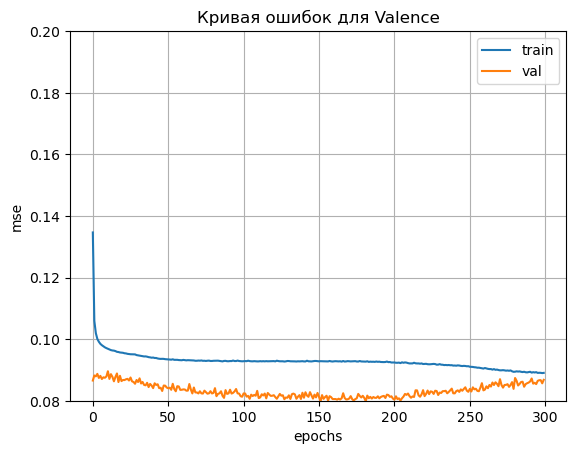

In [53]:
plot_history(history_valence, "Кривая ошибок для Valence", [0.08, 0.2])

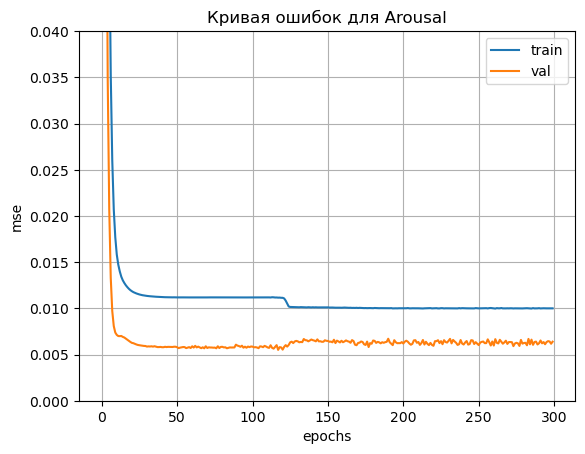

In [54]:
plot_history(history_arousal, "Кривая ошибок для Arousal", [0, 0.04])

### Модели с погружением

In [55]:
mtv_lag, history_valence_lag = model_NN(X_lag, y_valence_lag, X_test_lag, y_valence_test_lag, X_val_lag, y_valence_val_lag, 20, 1)
mta_lag, history_arousal_lag = model_NN(X_lag, y_arousal_lag, X_test_lag, y_arousal_test_lag, X_val_lag, y_arousal_val_lag, 20, 1)

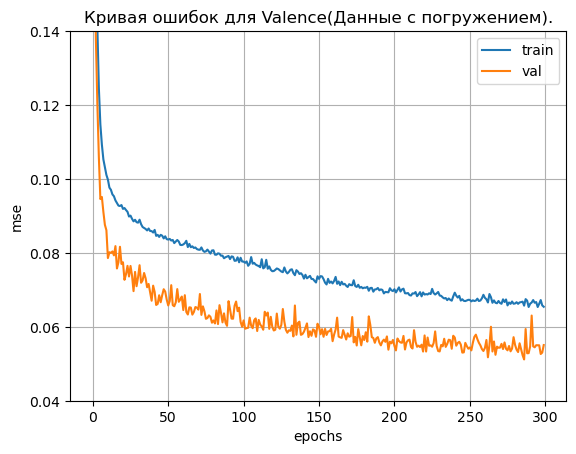

In [56]:
plot_history(history_valence_lag, "Кривая ошибок для Valence(Данные с погружением).", [0.04, 0.14])

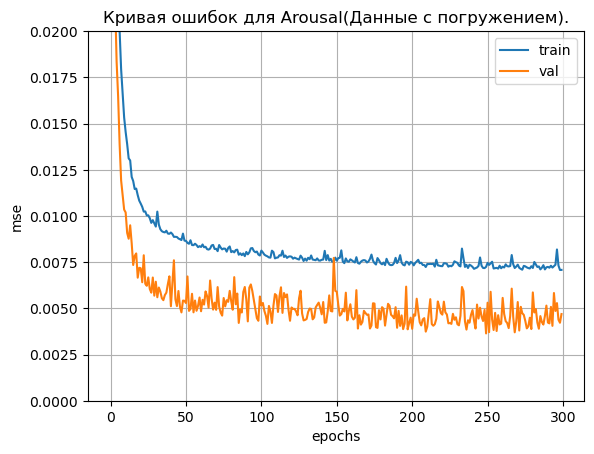

In [57]:
plot_history(history_arousal_lag, "Кривая ошибок для Arousal(Данные с погружением).", [0, 0.02])

# Сравнение моделей

In [58]:
# Valence
mtv['Модель'] = ["Без погружения и без подбора параметров"]
mtv_lag['Модель'] = ["С погружением, без подбора параметров"]
df_Valence = mtv.append(mtv_lag)

#Arousal
mta['Модель'] = ["Без погружения и без подбора параметров"]
mta_lag['Модель'] = ["С подбором параметров, без погружения"]
df_Arousal = mta.append(mta_lag)

### Отложенная выборка 

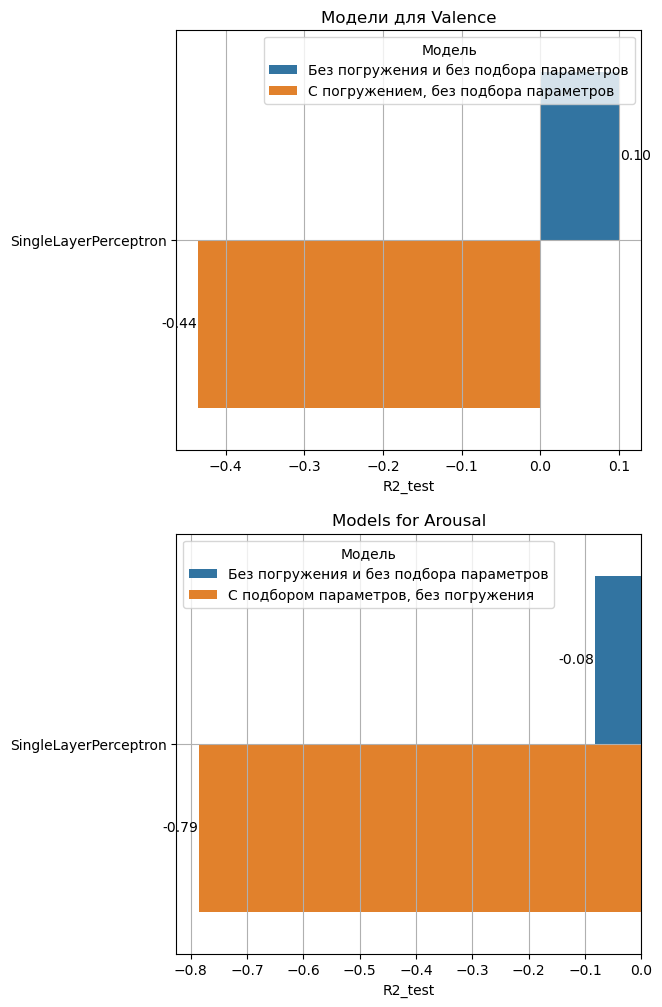

In [59]:
plt.figure(figsize=(6, 12))

plt.subplot(211)
ax = sns.barplot(data = df_Valence, x = 'R2_test', y = df_Valence.index, hue = 'Модель')
for container in ax.containers:
    ax.bar_label(container, size = 10, fmt = '%.2f')
plt.title('Модели для Valence')
plt.grid()

plt.subplot(212)
ax = sns.barplot(data = df_Arousal, x = 'R2_test', y = df_Arousal.index, hue = 'Модель')
for container in ax.containers:
    ax.bar_label(container, size = 10, fmt = '%.2f')
plt.title('Models for Arousal')
plt.grid()

plt.show()

## Тренировочная выборка

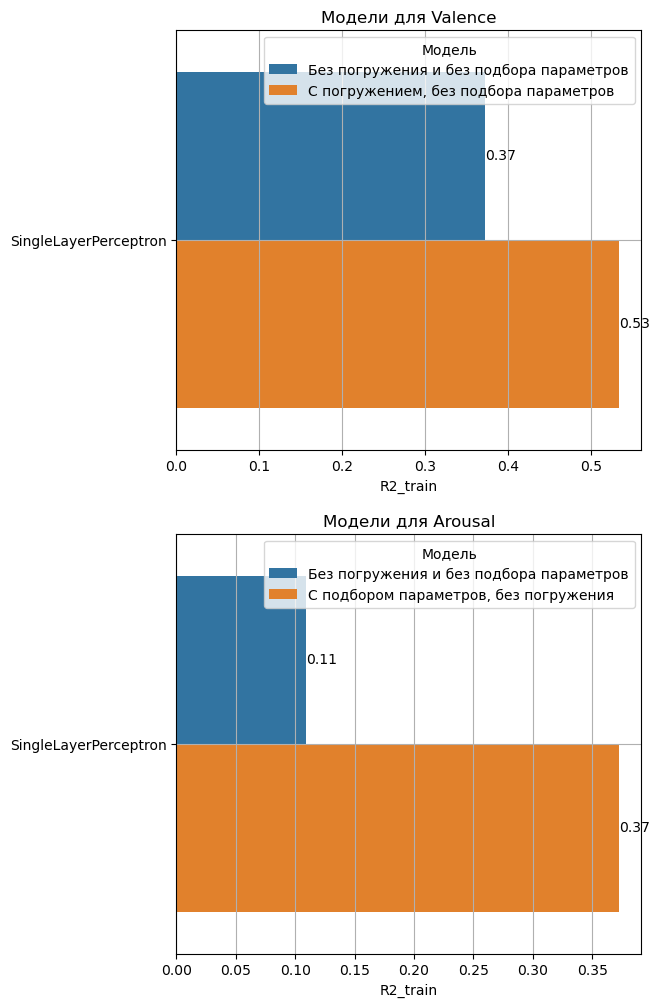

In [60]:
plt.figure(figsize=(6, 12))

plt.subplot(211)
ax = sns.barplot(data = df_Valence, x = 'R2_train', y = df_Valence.index, hue = 'Модель')
for container in ax.containers:
    ax.bar_label(container, size = 10, fmt = '%.2f')
plt.title('Модели для Valence')
plt.grid()

plt.subplot(212)
ax = sns.barplot(data = df_Arousal, x = 'R2_train', y = df_Arousal.index, hue = 'Модель')
for container in ax.containers:
    ax.bar_label(container, size = 10, fmt = '%.2f')
plt.title('Модели для Arousal')
plt.yticks()
plt.grid()

plt.show()

## Сохранение результатов работы моделей

In [127]:
with pd.ExcelWriter('Model_results.xlsx', mode="a") as writer:
    df_Arousal.to_excel(writer, sheet_name='Results_SingleLayerPerceptron_Arousal')
    df_Valence.to_excel(writer, sheet_name='Results_SingleLayerPerceptron_Valence')